# COGS 108 - Final Project 

# Overview

# Name & GitHub ID

- Name: Yichi Zhang
- GitHub Username: R1chZhang

# Research Question

Did public space worsen the traffic condition?

Improve-wise point of view: parking allows viehcles to be removed from sides of the road and thus propote traffic speed.

Deteriorate-wise point of view: parking areas take a lot of public space and thus increase populational density, resulting in more viehcles on unit area.

## Background and Prior Work

&emsp;Common literature on the relationship between public space and traffic is that public space such as parks reduces the street space and thus causing more traffic congestions. Research from Manville and Shoup, however, states that off-street parking in fact making traffic congestion worse because these constructions take a considerable amount of land, pushing the population in a denser area, and thus levitating the traffic density<sup>1</sup>. Manville and Shoup attribute this mechanism to the high speed of populational growth and the unmatching speed of urban planning and street development, but they draw their conclusion based on data whose minimum unit is the city. In other words, such a mechanism sketches sketch a general trend among regions, but it is not detailed to districts and streets. This leaves with us a space of uncertainty, especially when it comes to the urban planning of a specific city. In light of this, this project is interested in investigating whether Manville and Shoup's claim holds for the city of San Diego, so that it can be used to guide the city's development in the future.Predecessors of data analysts such as Aryandoust et al. have created a Hidden Markov Model that relating parking density to traffic density<sup>2</sup>. This research shows an example of linking usage of pulic space and traffic density.

References (include links):

1) Manville, Michael & Shoup, Donald. (2005). People, Parking and Cities. Journal of Urban Planning and Development. 131. 233-245. 10.1061/(ASCE)0733-9488(2005)131:4(233). https://www.researchgate.net/publication/235358939_People_Parking_and_Cities

2) Aryandoust, A., van Vliet, O. & Patt, A. City-scale car traffic and parking density maps from Uber Movement travel time data. Sci Data 6, 158 (2019). https://doi.org/10.1038/s41597-019-0159-6

# Hypothesis


Null Hypothesis: Population density around public space did not affect the traffic volume.

Alternative Hypothsis: Population density around public space leads to an increase in the traffic volume.

# Dataset(s)

- Dataset Name: California Park, Beach, Open Space, or Coastline Access
- Link to the dataset: https://data.ca.gov/dataset/park-beach-open-space-or-coastline-access
- Number of observations: 543187

This dataset contains the percent of residents within ½ mile of a public space(park, beach, open space, or coastline), geographic unit and county name of the space.


- Dataset Name: Annual Average Daily Traffic (AADT) Volumes
- Link to the dataset: https://data.ca.gov/dataset/fb62fd37-38e5-40a5-89d1-cb58ae12f244/resource/900d2d78-9344-47fa-8107-de383a2ef74a/download/tabular_aadt_2010.csv
- Number of observations: 5933

The dataset contains annual average daily traffic volume on each road, including the district and county name of the road.

&emsp;The primary goal of the project is to investigate whether demographic desity around public spaces is related to traffic volumes. To estimate the relationship, I plan to use `estimate` from CA Access data, which measures the percentage of residents within ½ mile of a open space, and the annual average daily traffic data(AADT), combined from `Ahead_AADT` and `Back_AADT` from AADT data. I will make a Suppport Vector regression among two data and use RMSE as a metric to evaluate the strength of the relationship, and use p_value obtained from t-test between the predicted AADT and the actual AADT to determine whether we reject or accept the null hypothesis. 

# Setup

In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# load data; this may takes a while since the file is over 500MB
df = pd.read_excel('hci_accesstoparks_469_ca_re_co_cd_pl_ct-7-3-2017-ada.xlsx')

In [4]:
AADT = pd.read_csv('tabular_aadt_2010.csv')

In [7]:
# a chart of Californian county names and their corresponding abbreviations
# help to establish link between county abbreviation in AADT dataset and full county name+code in Access to parks dataset
dictionary = pd.read_csv('county_name_code.txt',header=None,sep='\s-\s',names=['abbreviation','county_name'])
dictionary.head()

,abbreviation,county_name
0,ALA,Alameda
1,ALP,Alpine
2,AMA,Amador
3,BUT,Butte
4,CC,Contra Costa


# Data Cleaning

Describe your data cleaning steps here.

In [8]:
df.head()

,ind_id,ind_definition,reportyear,race_eth_code,race_eth_name,geotype,geotypevalue,geoname,county_fips,county_name,...,numerator,denominator,estimate,ll_95ci,ul_95ci,se,rse,ca_decile,ca_rr,version
0,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,78625.0,162250.0,48.459168,48.215988,48.702348,0.124071,0.256033,NaN,1.0,2017-07-03 11:02:07
1,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,11839.0,162250.0,7.296764,7.170210,7.423318,0.064568,0.884891,NaN,1.0,2017-07-03 11:02:07
2,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,12338.0,162250.0,7.604314,7.475335,7.733294,0.065806,0.865373,NaN,1.0,2017-07-03 11:02:07
3,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,4926.0,162250.0,3.036055,2.952568,3.119543,0.042596,1.403001,NaN,1.0,2017-07-03 11:02:07
4,469.0,"Percent of Population within 1/2 Mile of Park,...",2010.0,1.0,AIAN,CA,6.0,California,NaN,NaN,...,17147.0,162250.0,10.568259,10.418666,10.717852,0.076323,0.722190,NaN,1.0,2017-07-03 11:02:07


In [9]:
AADT.head()

,District,Route,County,Postmile,Description,Back_Peak_Hour,Back_Peak_Month,Back_AADT,Ahead_Peak_Hour,Ahead_Peak_Month,Ahead_AADT
0,12,1,ORA,R0.129,"DANA POINT, JCT. RTE. 5",0,0,0,3750,40000,37000
1,12,1,ORA,8.43,"LAGUNA BEACH, MOUNTAIN",2850,38500,36000,2850,38500,36000
2,12,1,ORA,9.418,"LAGUNA BEACH, RTE. 133 N.",2850,38500,36000,3600,43000,40000
3,12,1,ORA,19.797,"NEWPORT BEACH, RTE. 55",4100,50000,46000,4400,42500,40000
4,12,1,ORA,21.549,SANTA ANA RIVER BRIDGE,3550,34000,32000,4300,41500,39000


## Clean df

In [10]:
# report year, the reason why we choose 2010 AADT dataset instead of newer data
df.reportyear.value_counts()

2010.0    543186
Name: reportyear, dtype: int64

In [11]:
#drop columns that are not available according to the dictionary
df.drop(columns=['strata_two_code','strata_two_name'],inplace=True)

In [12]:
#the last row is for makring the end of the worksheet. Drop that too
df.iloc[-1]

ind_id                          NaN
ind_definition     End of Worksheet
reportyear                      NaN
race_eth_code                   NaN
race_eth_name                   NaN
geotype                         NaN
geotypevalue                    NaN
geoname                         NaN
county_fips                     NaN
county_name                     NaN
region_code                     NaN
region_name                     NaN
strata_one_code                 NaN
strata_one_name                 NaN
numerator                       NaN
denominator                     NaN
estimate                        NaN
ll_95ci                         NaN
ul_95ci                         NaN
se                              NaN
rse                             NaN
ca_decile                       NaN
ca_rr                           NaN
version                         NaT
Name: 543186, dtype: object

In [13]:
df.drop(index=543186,inplace=True)

## Clean AADT

In [14]:
AADT.County.unique()

array(['ORA', 'LA', 'VEN', 'SB', 'SLO', 'MON', 'SCR', 'SM', 'SF', 'MRN',
       'SON', 'MEN', 'SBD', 'TRI', 'SIS', 'CC', 'SJ', 'STA', 'CAL', 'ALP',
       'SD', 'KER', 'KIN', 'FRE', 'MER', 'SAC', 'YOL', 'COL', 'GLE',
       'TEH', 'SHA', 'INY', 'MNO', 'IMP', 'SCL', 'RIV', 'NAP', 'SOL',
       'ALA', 'AMA', 'LAK', 'SUT', 'YUB', 'NEV', 'PLA', 'SBT', 'BUT',
       'HUM', 'PLU', 'LAS', 'MAD', 'MPA', 'TUL', 'TUO', 'ED', 'SIE', 'DN',
       'MOD'], dtype=object)

In [15]:
dictionary.head()

,abbreviation,county_name
0,ALA,Alameda
1,ALP,Alpine
2,AMA,Amador
3,BUT,Butte
4,CC,Contra Costa


In [16]:
temp = dictionary.set_index('county_name')

In [17]:
# merge county abbreviation to main dataframe
df['County'] = df.county_name.apply(lambda x: temp.abbreviation[x] if type(x)==str else np.nan)

In [18]:
# aggregate ahead and back traffic volume
AADT['aggregated_AADT'] = AADT.Ahead_AADT+AADT.Back_AADT

# Data Analysis & Results

## Data Description and Preworks

&emsp; The project use two datasets from data.ca.gov. One is the <em>California Park, Beach, Open Space, or Coastline Access(shorted as CA Access)</em>, which. The other is the <em>Annual Average Daily Traffic (AADT) Volumes</em>, which measures the traffic counts on each county's roads. While more up-to-date data are available, the project decides to adopt AADT data of 2010 to be inline with the California parking data that also took the measurement in 2010.

&emsp;The primary goal of the project is to investigate whether demographic desity around public spaces is related to traffic volumes. To estimate the relationship, I plan to use `estimate` from CA Access data, which measures the percentage of residents within ½ mile of a open space, and the annual average daily traffic data(AADT), combined from `Ahead_AADT` and `Back_AADT` from AADT data. I will make a Support Vector regression among two data and use RMSE as a metric to evaluate the strength of the relationship, and use p_value obtained from t-test between the predicted AADT and the actual AADT to determine whether we reject or accept the null hypothesis. 

&emsp;To begin with, it would be essential to ensure that the geographic scope of AADT data is inline with CA Access. The CA Access dataset collects geographic unit ranging from CT(censcus tract) to CA(California State), while AADT contains geographic units of Districts, which is comprarable to CT in CA Access, and County, comparable to CO.

In [19]:
df.groupby('geotype').mean().estimate

geotype
CA    28.042001
CD    21.938540
CO    25.223910
CT    27.978559
PL    22.825138
RE    24.322386
Name: estimate, dtype: float64

By t-test with a threshold of 0.05, we ascertain that CD,CT,PL geographic types have similar distribution with CO(county) and thus can be used together for study, while more generalized geotypes such as RE(region) and CA(state) are different. In short, the model will adopt data with geotype CO,CD,CT and PL and ignore CA,RE in following steps.

In [20]:
ttest_ind(df.loc[df.geotype=='CO'].estimate.dropna(),df.loc[df.geotype=='CD'].estimate.dropna())

Ttest_indResult(statistic=5.544452796558487, pvalue=2.9797941012722257e-08)

In [21]:
ttest_ind(df.loc[df.geotype=='CO'].estimate.dropna(),df.loc[df.geotype=='CT'].estimate.dropna())

Ttest_indResult(statistic=-3.759495567842895, pvalue=0.00017027889024479826)

In [22]:
ttest_ind(df.loc[df.geotype=='CO'].estimate.dropna(),df.loc[df.geotype=='PL'].estimate.dropna())

Ttest_indResult(statistic=3.6878789323068366, pvalue=0.00022628889144191367)

In [23]:
ttest_ind(df.loc[df.geotype=='CO'].estimate.dropna(),df.loc[df.geotype=='RE'].estimate.dropna())

Ttest_indResult(statistic=0.7484046596260092, pvalue=0.45426154496722215)

In [24]:
ttest_ind(df.loc[df.geotype=='CO'].estimate.dropna(),df.loc[df.geotype=='CA'].estimate.dropna())

Ttest_indResult(statistic=-0.6750305501397625, pvalue=0.49970555503318137)

Generate dataframe for regression, using county as the minimum geographic unit.

In [35]:
df2 = df.loc[df.geotype.isin(['CO','CT','CD','PL'])]
df2 = df2.dropna(subset=['estimate','county_name'])

In [64]:
df2[['County','estimate']].groupby('County').mean().shape[0]

58

In [65]:
AADT[['County','aggregated_AADT']].groupby('County').mean().shape[0]

58

In [69]:
df3 = pd.concat([df2[['County','estimate']].groupby('County').mean(),
                 AADT[['County','aggregated_AADT']].groupby('County').mean()],axis=1,join='inner')
df3.shape

(44, 2)

In [71]:
df3

,estimate,aggregated_AADT
County,,
ALA,33.446114,157996.242775
ALP,31.597988,2842.500000
AMA,13.533711,15965.909091
BUT,18.458739,28942.527473
COL,18.693014,25242.352941
FRE,19.834707,61357.835052
GLE,10.357625,15748.000000
HUM,21.054139,23522.649573
IMP,21.600322,23624.251497


By running a SVR, we end up with a RMSE<0, suggesting that trafic volume have nearly no relationship to populational density around the public recreation space.

In [72]:
X,y = df3.estimate,df3.aggregated_AADT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [74]:
svr = SVR()
svr.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))

SVR()

In [75]:
svr.score(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))

-0.16579640183673106

However, looking back at the rse of CA Access dataset, it has brought to the attention that only about 20% of the estimates have rse below 30%, while the rest are ≥ 30% and are deemed as unreliable accroding to the dataset dictionary and [program document](http://www.cdph.ca.gov/programs/ohir/Documents/OHIRProfiles2014.pdf).

In [91]:
(df2.rse<30).value_counts()

False    422786
True      99190
Name: rse, dtype: int64

Text(0.5, 1.0, 'distribution of rse')

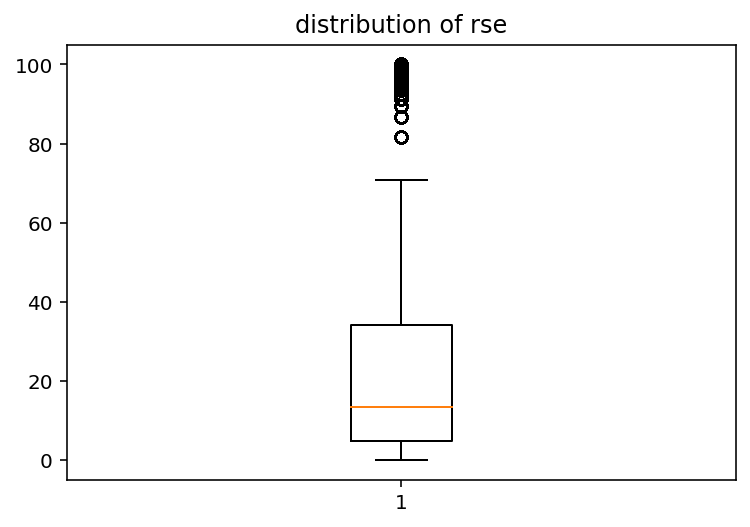

In [110]:
plt.boxplot(df2.rse.dropna())
plt.title('distribution of rse')

After eliminate unreliable data

In [113]:
df3 = pd.concat([df2.dropna(subset=['rse']).loc[df2.rse<30][['County','estimate']].groupby('County').mean(),
                 AADT[['County','aggregated_AADT']].groupby('County').mean()],axis=1,join='inner')

In [115]:
X,y = df3.estimate,df3.aggregated_AADT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [131]:
svr = SVR()
svr.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))

SVR()

In [132]:
svr.score(X.values.reshape(-1,1),y.values.reshape(-1,1))

-0.11232116486863908

SVR prove to perform badly on the given dataset; try linear and polynomial regression instead

In [165]:
reg = LinearRegression()
reg.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))

LinearRegression()

In [166]:
reg.score(X.values.reshape(-1,1),y.values.reshape(-1,1))

0.2431927883962124

In [174]:
scaler = StandardScaler()
r2 = []
for i in range(2,11):
    degree=i
    polyreg=make_pipeline(PolynomialFeatures(degree),scaler,LinearRegression())
    polyreg.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))
    r2.append(polyreg.score(X.values.reshape(-1,1),y.values.reshape(-1,1)))

In [176]:
r2 = pd.Series(r2,index = np.arange(2,11))
r2

2     0.334192
3     0.340352
4     0.341950
5     0.358456
6     0.360957
7     0.379032
8     0.398638
9     0.226503
10   -0.049326
dtype: float64

In [179]:
r2.idxmax(),r2.max()

(8, 0.398637765625369)

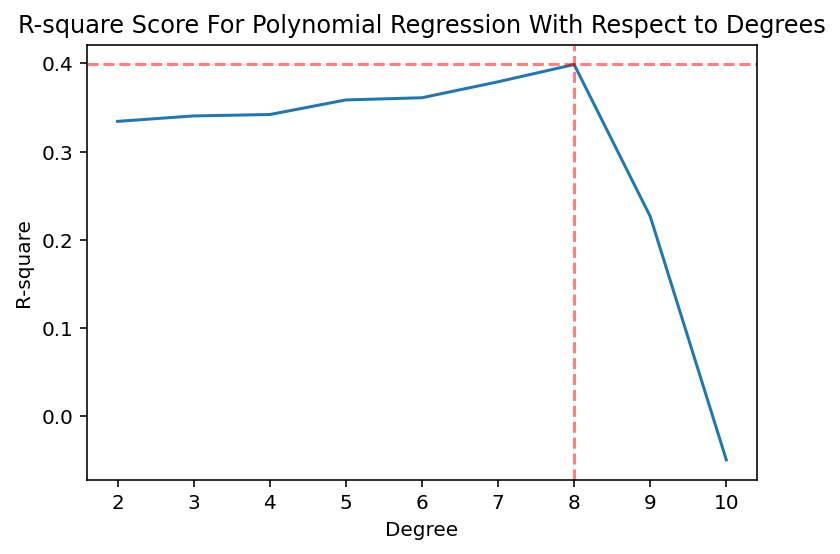

In [194]:
plt.plot(r2)
plt.title('R-square Score For Polynomial Regression With Respect to Degrees')
plt.xlabel('Degree')
plt.ylabel('R-square')
plt.axvline(8,color='r',alpha=0.5,ls='--')
plt.axhline(r2.max(),color='r',alpha=0.5,ls='--')

After conducting linear and polynomial regressions, we choose a polynomial regression of degree 8, with a RMSE of 0.398, which indicates a weak relationship.

### Hypothesis Testing

In [195]:
final_model =make_pipeline(PolynomialFeatures(8),scaler,LinearRegression())
final_model.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=8)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [199]:
result = ttest_ind(final_model.predict(X.values.reshape(-1,1)),y.values.reshape(-1,1))
result

Ttest_indResult(statistic=array([-0.04798013]), pvalue=array([0.96184333]))

With a p-value of 0.96>0.95, we conclude that traffic volume is positively affected by the presence of public space and population density surround the space.

Text(0.5, 1.0, 'Hypothesis Testing on the Distribution')

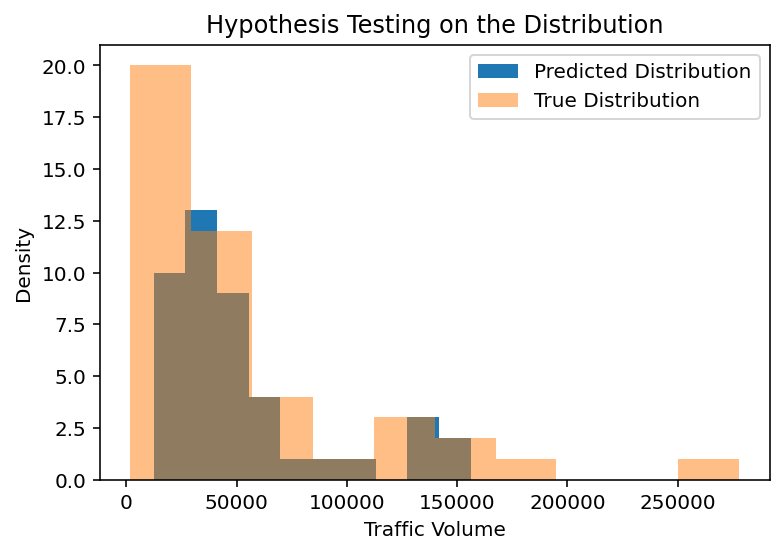

In [213]:
plt.hist(final_model.predict(X.values.reshape(-1,1)))
plt.hist(y.values.reshape(-1,1),alpha=0.5)
plt.legend(['Predicted Distribution','True Distribution'])
plt.xlabel('Traffic Volume')
plt.ylabel('Density')
plt.title('Hypothesis Testing on the Distribution')

# Ethics & Privacy

&emsp;Data presented in this project does not inflict with any private or personal information, and most data can be found publicly from Uber or other institutions. There might be concerns that documents related to city planning cannot be made public without governmental permissions, but given that the data this project plans to use is purely for the observational purpose, and one can gather the same information(whether a parking area is on-street or not) merely by its eyes, the possibility of such concerns came to be an obstacle would be small.<br/>

&emsp;The carrier of the project is well alarmed that possible conclusions made by this research might influence the function of some public service area such as schools and hospitals, which, if shall be deprived of some parking spaces under the advice of the project's conclusion, might result in significant damage on the society. The project carrier is also alarmed that regulating city planning by parking and traffics is innately biased to people without vehicles, which may be conflicted with principles of social justice. That been said, the result of this project is purely suggestional, and its purpose is to provide insights on the relationship between parking and traffics, which can be used as one of many dimensions when planning the city in the future.

# Conclusion & Discussion

With a p-value of 0.96>0.95, we conclude that traffic volume is positively related to the presence of public space and population density surround the space. The project confirm Manville and Michael's claim on construction of public spaces, whether by nature(such as beach or coastline) or by planning(parks), do leads to an increse in the traffic volume in that area, and potentially slower the traffic speed.